In [27]:
import pandas as pd
import numpy as np

from numpy import ndarray
from util.base import Data
from util.visualizerNN import NetVisualizer

from lincoln.activations import Sigmoid, Tanh, ReLU, Linear
from lincoln.train import Trainer
from lincoln.optimizers import SGD, SGDMomentum
from lincoln.network import NeuralNetwork
from lincoln.layers import Dense
from lincoln.losses import SoftmaxCrossEntropy, MeanSquaredError
from lincoln.np_utils import to_2d

## <span style="color: blue"> **Einlesen, Analysieren und Vorverarbeiten der Daten** </span>

### DataFrame aus der csv-Datei einlesen

In [28]:
csvFile="data/Konsumkredit.csv"
df = pd.read_csv(csvFile)
df

,Geschlecht,Familienstand,Kinder,Beruf,Wohneigentum,Einkommen,Ersparnisse,kreditwuerdig
0,W,V,1,ungelernt,N,2514,N,N
1,M,V,0,ungelernt,N,2285,J,N
2,M,V,1,angelernt,N,3468,N,N
3,W,V,0,unbekannt,N,2172,N,N
4,M,W,1,Facharbeiter,J,2101,J,N
...,...,...,...,...,...,...,...,...
2419,M,V,1,unbekannt,N,3241,J,J
2420,W,V,1,Facharbeiter,N,3362,J,J
2421,M,V,1,Facharbeiter,N,3618,J,J
2422,W,V,2,Facharbeiter,N,3169,J,J


### Zielvariable (label) festlegen

In [29]:
classLabel = 'N_kreditwuerdig'

### Vorverarbeitung 
- binäre Werte: eine neue Spalte => 1,0
- nominale Werte: je Werte eine neue Spalte => [1,...,0] ... [0,...,1]
- numerische Werte: eine neue Spalte mit Normierung zwischen Minwert und Maxwert  =>  0...1

In [30]:
# binäre Werte
column = 'kreditwuerdig'
df[f'N_{column}'] = np.where(df[column] == 'J', 1, 0)

column = 'Geschlecht'
df[f'N_{column}'] = np.where(df[column] == 'M', 1, 0)

# nominale Werte
column = 'Familienstand'
for value in df[column].unique():
    df[f'N_{column}{value}'] = np.where(df[column] == value, 1, 0)

# numerische Werte x1 und x2: je eine neue Spalte (N_x1 und N_x2) mit normierten Werten zwischen 0 und 1   
column = 'Kinder'
df[f'N_{column}'] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

# nominal
column = 'Beruf'
for value in df[column].unique():
    df[f'N_{column}{value}'] = np.where(df[column] == value, 1, 0)

# binär
column = 'Wohneigentum'
df[f'N_{column}'] = np.where(df[column] == 'J', 1, 0)

# numerisch
column = 'Einkommen'
df[f'N_{column}'] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

# binär
column = 'Ersparnisse'
df[f'N_{column}'] = np.where(df[column] == 'J', 1, 0)


# <span style="color: blue"> **Initialisieren der Daten für die Modellerstellung** </span>

### Berechnung initialisieren und dabei Split in Trainungs-, Validierungs- und Testdatenmenge durchführen

In [31]:
listOfAttributes = []
data = Data(df = df)
data.initialize(listOfAttributes = listOfAttributes, classLabel = classLabel, trainProportion=0.65, valProportion=0.15)

### Trainingsdaten

In [32]:
mask = df['_split'] == 'train'
df[mask]

,Geschlecht,Familienstand,Kinder,Beruf,Wohneigentum,Einkommen,Ersparnisse,kreditwuerdig,N_kreditwuerdig,N_Geschlecht,...,N_Berufangelernt,N_Berufunbekannt,N_BerufFacharbeiter,N_BerufBuerokraft,N_BerufManager,N_BerufLehrer,N_Wohneigentum,N_Einkommen,N_Ersparnisse,_split
1,M,V,0,ungelernt,N,2285,J,N,0,1,...,0,0,0,0,0,0,0,0.042707,1,train
4,M,W,1,Facharbeiter,J,2101,J,N,0,1,...,0,0,1,0,0,0,1,0.016600,1,train
7,M,V,2,Facharbeiter,J,2538,J,N,0,1,...,0,0,1,0,0,0,1,0.078604,1,train
8,W,W,0,Facharbeiter,N,2818,N,N,0,0,...,0,0,1,0,0,0,0,0.118331,0,train
9,W,V,2,angelernt,N,2762,N,N,0,0,...,1,0,0,0,0,0,0,0.110386,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2417,M,V,1,Lehrer,N,3707,J,J,1,1,...,0,0,0,0,0,1,0,0.244467,1,train
2418,M,W,1,angelernt,N,3696,J,J,1,1,...,1,0,0,0,0,0,0,0.242906,1,train
2419,M,V,1,unbekannt,N,3241,J,J,1,1,...,0,1,0,0,0,0,0,0.178348,1,train
2420,W,V,1,Facharbeiter,N,3362,J,J,1,0,...,0,0,1,0,0,0,0,0.195516,1,train


### Testdaten

In [33]:
mask = df['_split'] == 'test'
df[mask]

,Geschlecht,Familienstand,Kinder,Beruf,Wohneigentum,Einkommen,Ersparnisse,kreditwuerdig,N_kreditwuerdig,N_Geschlecht,...,N_Berufangelernt,N_Berufunbekannt,N_BerufFacharbeiter,N_BerufBuerokraft,N_BerufManager,N_BerufLehrer,N_Wohneigentum,N_Einkommen,N_Ersparnisse,_split
3,W,V,0,unbekannt,N,2172,N,N,0,0,...,0,1,0,0,0,0,0,0.026674,0,test
5,M,V,1,angelernt,J,2634,J,N,0,1,...,1,0,0,0,0,0,1,0.092225,1,test
10,W,V,0,ungelernt,N,2583,N,N,0,0,...,0,0,0,0,0,0,0,0.084989,0,test
12,M,W,1,ungelernt,N,2076,J,N,0,1,...,0,0,0,0,0,0,0,0.013053,1,test
15,W,V,2,unbekannt,J,2432,N,N,0,0,...,0,1,0,0,0,0,1,0.063564,0,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,W,L,1,Facharbeiter,N,3418,J,J,1,0,...,0,0,1,0,0,0,0,0.203462,1,test
2397,W,V,1,unbekannt,N,5669,J,J,1,0,...,0,1,0,0,0,0,0,0.522843,1,test
2403,M,V,2,Manager,N,3521,J,J,1,1,...,0,0,0,0,1,0,0,0.218076,1,test
2406,W,V,1,Lehrer,N,8860,J,J,1,0,...,0,0,0,0,0,1,0,0.975596,1,test


### Validierungsdaten

In [34]:
mask = df['_split'] == 'val'
df[mask]

,Geschlecht,Familienstand,Kinder,Beruf,Wohneigentum,Einkommen,Ersparnisse,kreditwuerdig,N_kreditwuerdig,N_Geschlecht,...,N_Berufangelernt,N_Berufunbekannt,N_BerufFacharbeiter,N_BerufBuerokraft,N_BerufManager,N_BerufLehrer,N_Wohneigentum,N_Einkommen,N_Ersparnisse,_split
0,W,V,1,ungelernt,N,2514,N,N,0,0,...,0,0,0,0,0,0,0,0.075199,0,val
2,M,V,1,angelernt,N,3468,N,N,0,1,...,1,0,0,0,0,0,0,0.210556,0,val
6,M,V,0,unbekannt,N,2402,J,N,0,1,...,0,1,0,0,0,0,0,0.059308,1,val
18,W,V,1,Manager,N,3945,N,N,0,0,...,0,0,0,0,1,0,0,0.278235,0,val
19,W,V,1,ungelernt,N,2375,N,N,0,0,...,0,0,0,0,0,0,0,0.055477,0,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2404,M,V,2,Lehrer,N,7655,J,J,1,1,...,0,0,0,0,0,1,0,0.804625,1,val
2405,M,V,2,Lehrer,J,8236,J,J,1,1,...,0,0,0,0,0,1,1,0.887060,1,val
2413,M,V,2,Manager,N,5196,J,J,1,1,...,0,0,0,0,1,0,0,0.455732,1,val
2414,M,L,1,Facharbeiter,N,5723,J,J,1,1,...,0,0,1,0,0,0,0,0.530505,1,val


### Zusammenfassung des Split-Ergebnis

In [35]:
dfSplit = data.splitCheck()
dfSplit

,Anzahl Datensätze,Anteil an Gesamt,Anzahl '0',Anteil '0',Anzahl '1',Anteil '1'
Gesamt,2424,1.000000,1290,0.532178,1134,0.467822
Trainingsdaten,1575,0.649752,838,0.532063,737,0.467937
Validierungsdaten,363,0.149752,193,0.531680,170,0.468320
Testdaten,486,0.200495,259,0.532922,227,0.467078


### Liste der normierten (!) Predictorvariablen (features) festlegen

In [36]:
listOfAttributes = ['N_Geschlecht', 'N_FamilienstandV', 
'N_FamilienstandW', 'N_FamilienstandL',
'N_Kinder', 'N_Berufungelernt', 'N_Berufangelernt', 
'N_Berufunbekannt', 'N_BerufFacharbeiter', 'N_BerufBuerokraft',
'N_BerufManager', 'N_BerufLehrer', 'N_Wohneigentum', 'N_Einkommen', 
'N_Ersparnisse']

### ndArrays der Trainings-, Validierungs- und Testdaten erzeugen

In [37]:
trainAttributes = data.Df[listOfAttributes].loc[data.Df['_split'] == 'train'].to_numpy()
trainLabel = data.Df[classLabel].loc[data.Df['_split'] == 'train'].to_numpy()
valAttributes = data.Df[listOfAttributes].loc[data.Df['_split'] == 'val'].to_numpy()
valLabel = data.Df[classLabel].loc[data.Df['_split'] == 'val'].to_numpy()
testAttributes = data.Df[listOfAttributes].loc[data.Df['_split'] == 'test'].to_numpy()
testLabel = data.Df[classLabel].loc[data.Df['_split'] == 'test'].to_numpy()
testIndizes = data.Df.loc[data.Df['_split'] == 'test'].index.to_numpy()

### 2D-Array der Zielvariablen (label)

In [38]:
trainLabel, valLabel, testLabel = to_2d(trainLabel), to_2d(valLabel), to_2d(testLabel)

# <span style="color: blue"> **Anlegen, Trainieren, Testen und Visualisieren des Neuronales Netzes** </span>

### Anlegen des Netzes mit einem verdeckten Schicht

In [39]:
# Definition von Netzstruktur, Aktivierungsfunktionen und Verlustfunktion
model = NeuralNetwork(
        layers=[
                # hidden layer
                Dense(neurons=40,
                     activation=Sigmoid()),
                # output layer
                Dense(neurons=1,
                    activation=Sigmoid())
                ],
        loss=MeanSquaredError()
        )

### Optimierungsverfahren

In [40]:
optimierer = SGDMomentum(lr=0.1)
#optimierer = SGD(lr= 0.1)

### Training

In [41]:
trainer = Trainer(net=model, optim=optimierer)
trainer.fit(trainAttributes, trainLabel, valAttributes, valLabel,
                epochs=4000,
                eval_every=100,
                seed= 12345,
                batch_size= 20)

Validation loss after 100 epochs is 0.092
Validation loss after 200 epochs is 0.088
Validation loss after 300 epochs is 0.080
Validation loss after 400 epochs is 0.078

Loss increased after epoch 500, final loss was 0.078, 
using the model from epoch 400


### Anwendung des Modells (des trainierten Netz) auf die Testdaten

In [42]:
# Loss der Anwendung
modellResult = trainer.net.forward(testAttributes)
loss = trainer.net.loss.forward(modellResult, testLabel)
loss

0.07706425565763961

### Ausgabe des Ergebnis der Modellanwendung

In [43]:
# flatten() erzeugt einen 1D-Array
resultOfModel = pd.Series(modellResult.flatten(), index = testIndizes)
real  = pd.Series(testLabel.flatten(), index = testIndizes)

# pd.concat liefert pd.DataFrame
dataframeOfResult = pd.concat([data.Df[classLabel].loc[data.Df['_split'] == 'test'],\
                real, resultOfModel], axis = 1)
dataframeOfResult.columns = [classLabel, 'Real', 'Modell_exakt'] 

# Ergebnis der Modellanwendung mittels Toleranz auf die Label 0 und 1 runden
toleranz = 0.25
conditionlist = [
    (dataframeOfResult['Modell_exakt'] >= 0-toleranz) & (dataframeOfResult['Modell_exakt'] <= 0+toleranz),
    (dataframeOfResult['Modell_exakt'] >= 1-toleranz) & (dataframeOfResult['Modell_exakt'] <= 1+toleranz)]
choicelist = [0, 1]   
dataframeOfResult['Modell'] = np.select(conditionlist, choicelist, default='unbestimmt')

dataframeOfResult

,N_kreditwuerdig,Real,Modell_exakt,Modell
3,0,0,2.044870e-09,0
5,0,0,3.698129e-03,0
10,0,0,4.582721e-10,0
12,0,0,1.937208e-05,0
15,0,0,9.839794e-10,0
...,...,...,...,...
2395,1,1,9.602271e-01,1
2397,1,1,9.999818e-01,1
2403,1,1,4.031240e-01,unbestimmt
2406,1,1,1.000000e+00,1


### Ausgabe des Tests als Kreuztabelle

In [44]:
crossTable = pd.crosstab(dataframeOfResult['Modell'],
                             dataframeOfResult['Real'],
                             margins= True, margins_name='Summe')    
crossTable

Real,0,1,Summe
Modell,,,
0,224,16,240
1,19,201,220
unbestimmt,16,10,26
Summe,259,227,486


### Ausgabe des Netzstruktur als Grafik

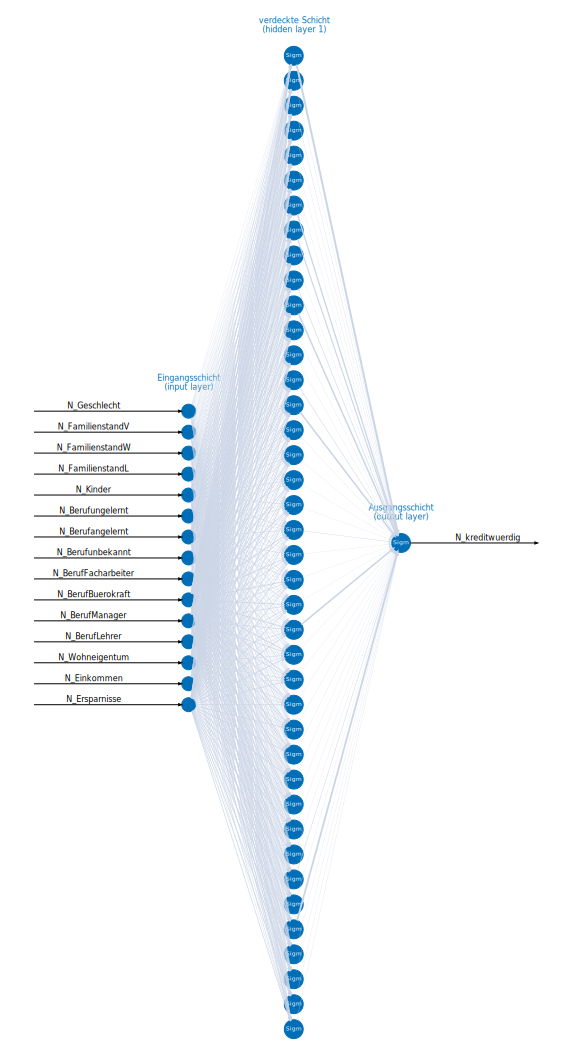

In [45]:
vs = NetVisualizer()
dot = vs.DrawNet(net = model, listOfInput = listOfAttributes, listOfOutput = [classLabel], nodesep = 0.1, ranksep= 0.3, showWeights = False)
dot

# <span style="color: blue"> **Neuronales Netz mit zwei verdeckten Schichten** </span>

### Anlegen des Netzes

In [46]:
# Definition von Netzstruktur, Aktivierungsfunktionen und Verlustfunktion
model = NeuralNetwork(
        layers=[
                # hidden layer 1
                Dense(neurons=4,
                     activation=Sigmoid()),
                # hidden layer 2
                Dense(neurons=2,
                     activation=Sigmoid()),                
                # output layer
                Dense(neurons=1,
                    activation=Sigmoid())
                ],
        loss=MeanSquaredError()
        )

### Optimierungsverfahren

In [47]:
optimierer = SGDMomentum(lr=0.1)
#optimierer = SGD(lr= 0.1)

### Training

In [48]:
trainer = Trainer(net=model, optim=optimierer)
trainer.fit(trainAttributes, trainLabel, valAttributes, valLabel,
                epochs=2000,
                eval_every=100,
                seed= 12345,
                batch_size= 20)

Validation loss after 100 epochs is 0.091
Validation loss after 200 epochs is 0.082
Validation loss after 300 epochs is 0.080
Validation loss after 400 epochs is 0.080

Loss increased after epoch 500, final loss was 0.080, 
using the model from epoch 400


### Anwendung des Modells auf die Testdaten

In [49]:
# Loss der Anwendung
modellResult = trainer.net.forward(testAttributes)
loss = trainer.net.loss.forward(modellResult, testLabel)
loss

0.08851697021998123

### Ausgabe des Ergebnis der Modellanwendung

In [50]:
# flatten() erzeugt einen 1D-Array
resultOfModel = pd.Series(modellResult.flatten(), index = testIndizes)
real  = pd.Series(testLabel.flatten(), index = testIndizes)

# pd.concat liefert pd.DataFrame
dataframeOfResult = pd.concat([data.Df[classLabel].loc[data.Df['_split'] == 'test'],\
                real, resultOfModel], axis = 1)
dataframeOfResult.columns = [classLabel, 'Real', 'Modell_exakt'] 

# Ergebnis der Modellanwendung mittels Toleranz auf die Label 0 und 1 runden
toleranz = 0.25
conditionlist = [
    (dataframeOfResult['Modell_exakt'] >= 0-toleranz) & (dataframeOfResult['Modell_exakt'] <= 0+toleranz),
    (dataframeOfResult['Modell_exakt'] >= 1-toleranz) & (dataframeOfResult['Modell_exakt'] <= 1+toleranz)]
choicelist = [0, 1]   
dataframeOfResult['Modell'] = np.select(conditionlist, choicelist, default='unbestimmt')

dataframeOfResult

,N_kreditwuerdig,Real,Modell_exakt,Modell
3,0,0,0.041560,0
5,0,0,0.041515,0
10,0,0,0.041930,0
12,0,0,0.042034,0
15,0,0,0.040478,0
...,...,...,...,...
2395,1,1,0.940005,1
2397,1,1,0.948581,1
2403,1,1,0.109321,0
2406,1,1,0.949581,1


### Ausgabe des Tests als Kreuztabelle

In [51]:
crossTable = pd.crosstab(dataframeOfResult['Modell'],
                             dataframeOfResult['Real'],
                             margins= True, margins_name='Summe')    
crossTable

Real,0,1,Summe
Modell,,,
0,225,21,246
1,21,196,217
unbestimmt,13,10,23
Summe,259,227,486


### Ausgabe des Netzstruktur als Grafik

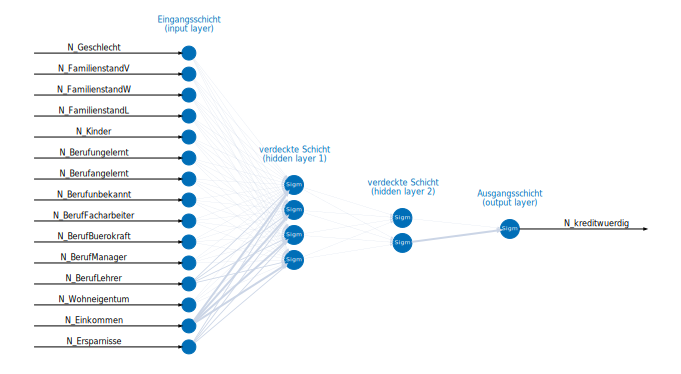

In [52]:
vs = NetVisualizer()
dot = vs.DrawNet(net = model, listOfInput = listOfAttributes, listOfOutput = [classLabel], nodesep = 0.1, ranksep= 0.3, showWeights = False)
dot